In [1]:
# Student Performance Prediction Model
# Machine Learning project to predict student final grades using various academic and demographic features

import pandas as pd
import numpy as np

student_data = pd.read_csv('student-mat.csv')

In [2]:
# Load and explore data

student_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   school       395 non-null    object 
 1   sex          395 non-null    object 
 2   age          383 non-null    float64
 3   address      395 non-null    object 
 4   famsize      395 non-null    object 
 5   Pstatus      395 non-null    object 
 6   Medu         395 non-null    int64  
 7   Fedu         395 non-null    int64  
 8   Mjob         395 non-null    object 
 9   Fjob         395 non-null    object 
 10  reason       395 non-null    object 
 11  guardian     395 non-null    object 
 12  traveltime   395 non-null    int64  
 13  studytime    395 non-null    int64  
 14  failures     395 non-null    int64  
 15  schoolsup    395 non-null    object 
 16  famsup       395 non-null    object 
 17  paid         395 non-null    object 
 18  activities   395 non-null    object 
 19  nursery 

In [3]:
student_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,goout,Dalc,Walc,health,absences_G1,absences_G2,absences_G3,G1,G2,G3
0,GP,F,18.0,U,GT3,A,4,4,at_home,teacher,...,4,1,1,3,1.0,0.0,4.0,5,6,6
1,GP,F,17.0,U,GT3,T,1,1,at_home,other,...,3,1,1,3,NaN,0.0,1.0,5,5,6
2,GP,F,15.0,U,LE3,T,1,1,at_home,other,...,2,2,3,3,1.0,2.0,8.0,7,8,10
3,GP,F,15.0,U,GT3,T,4,2,health,services,...,2,1,1,5,0.0,1.0,2.0,15,14,15
4,GP,F,NaN,U,GT3,T,3,3,other,other,...,2,1,2,5,0.0,0.0,4.0,6,10,10


In [4]:
# Seperate target from features to define X and Y 

final_grade = student_data["G3"]
student_features = student_data.drop("G3", axis=1)

In [5]:
# Train/test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    student_features, 
    final_grade,
    test_size=0.2,
    random_state=42
)

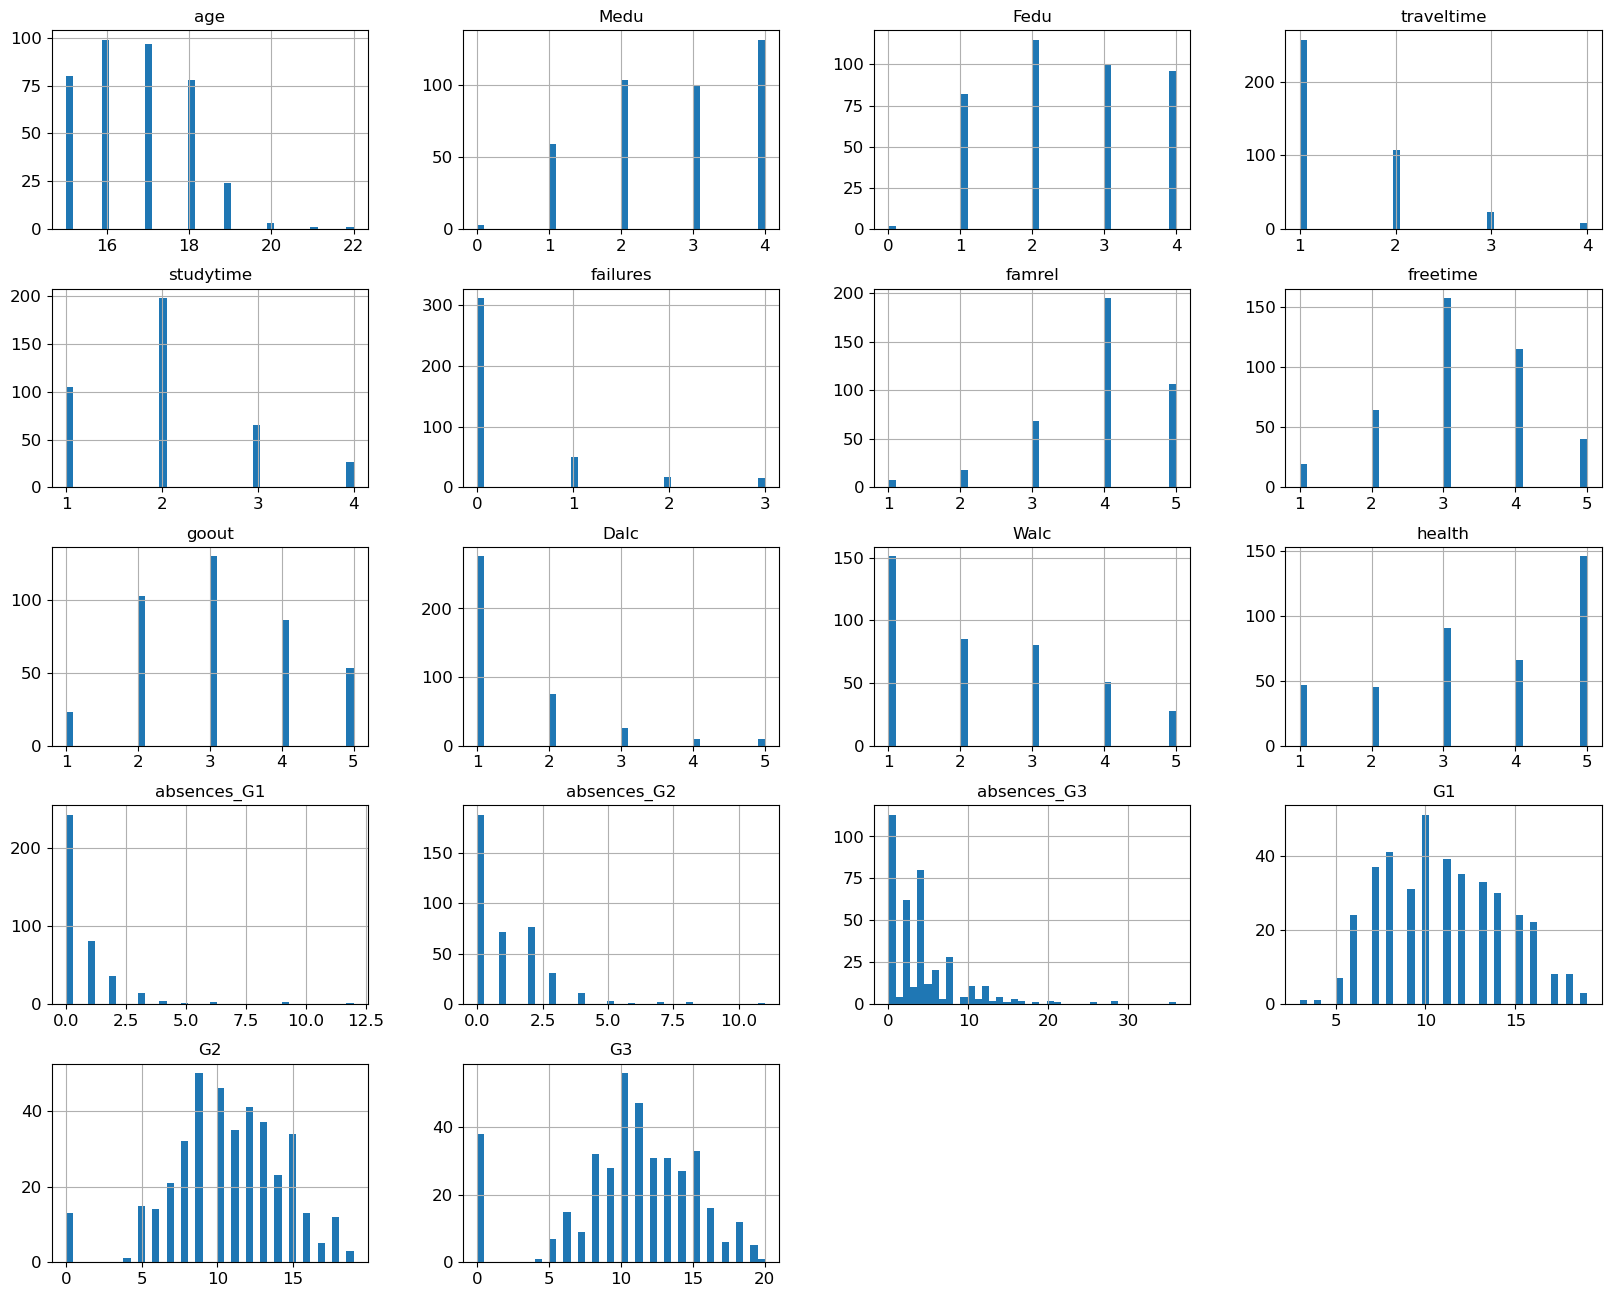

In [6]:
# Make a copy of training data for exploration 

explore_data = student_data.copy()

import matplotlib.pyplot as plt

# extra formatting 
plt.rc('font', size=12)
plt.rc('axes', labelsize=12, titlesize=12)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# plots histogram of numerical data
explore_data.hist(bins=40, figsize=(20, 16))
plt.show()

In [7]:
# Create numeric column
num_cols = ["age","Medu","Fedu","traveltime","studytime","failures","famrel",
            "freetime","goout","Dalc","Walc","health","absences_G1","absences_G2",
            "absences_G3","G1","G2","G3"
]

# Compute correlations 
corr_matrix = student_data[num_cols].corr()
G3_corr = corr_matrix["G3"].sort_values(ascending=False)
print(G3_corr)

G3             1.000000
G2             0.904868
G1             0.801468
Medu           0.217147
Fedu           0.152457
studytime      0.097820
absences_G3    0.086384
famrel         0.051363
absences_G2    0.041598
freetime       0.011307
absences_G1    0.008686
Walc          -0.051939
Dalc          -0.054660
health        -0.061335
traveltime    -0.117142
goout         -0.132791
age           -0.152762
failures      -0.360415
Name: G3, dtype: float64


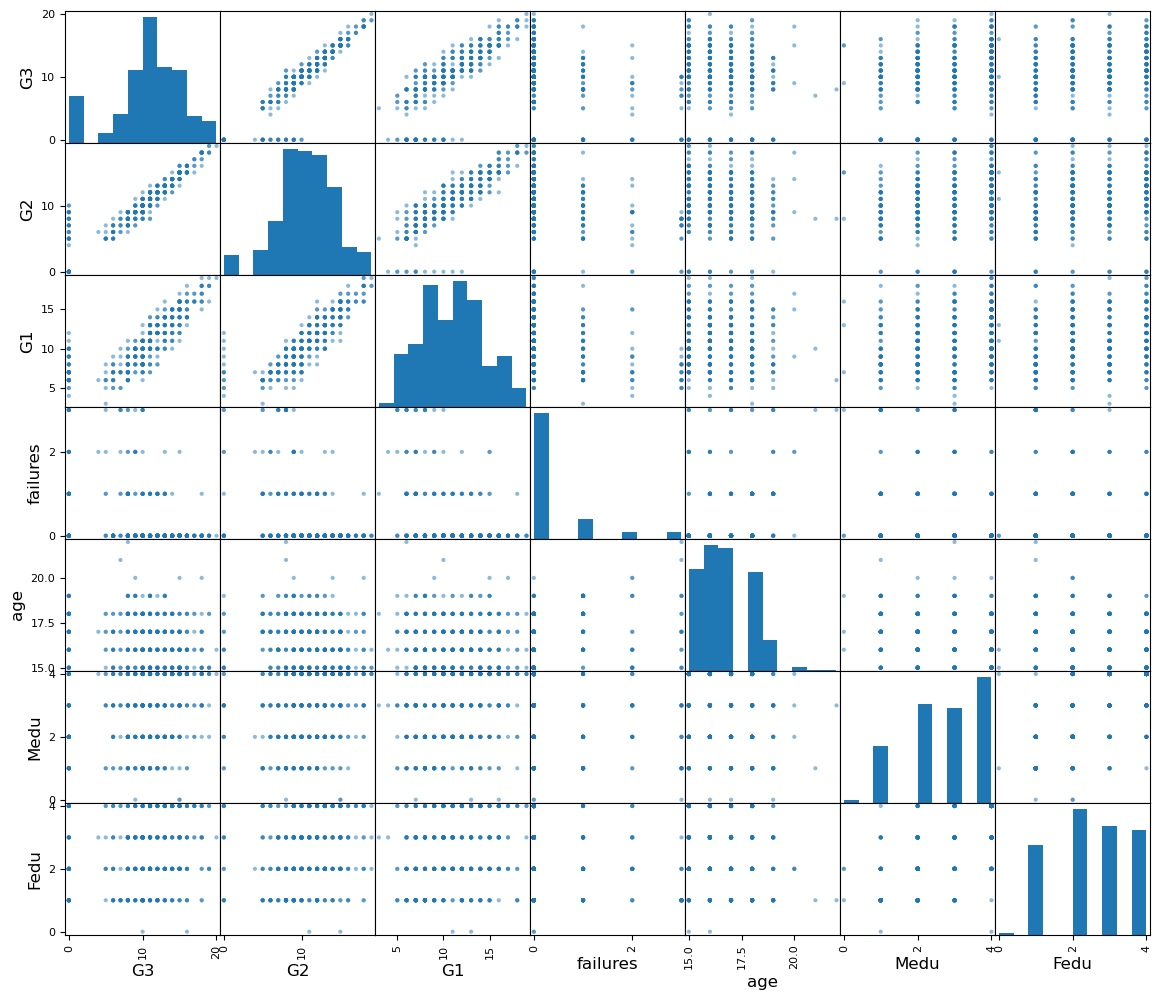

In [8]:
# Scatter matrix with attributes with the strongest correlations 

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

attributes = ["G3", "G2", "G1", "failures", "age", "Medu", "Fedu"]

scatter_matrix(student_data[attributes], figsize=(14, 12))
plt.show()

In [9]:
numeric_columns = ["absences_G1", "absences_G2", "absences_G3","G1", "G2", "age", "failures"]

categorical_columns = ["sex", "school", "address"]

ordinal_columns = ["Medu", "Fedu", "studytime"]

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class FinalProjectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_grades=True):
        self.drop_grades = drop_grades
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["absences_sum"] = X[["absences_G1", "absences_G2", "absences_G3"]].sum(axis=1)
        X = X.drop(columns=["absences_G1", "absences_G2", "absences_G3"])
        if self.drop_grades:
            X = X.drop(columns=["G1", "G2"])
        return X 

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# numeric pipelines 
numeric_pipeline_with_grades = make_pipeline(
    SimpleImputer().set_output(transform="pandas"),
    FinalProjectTransformer(drop_grades=False),
    StandardScaler()
)

numeric_pipeline_without_grades = make_pipeline(
    SimpleImputer().set_output(transform="pandas"),
    FinalProjectTransformer(drop_grades=True),
    StandardScaler()
)

# categorical pipeline
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(drop="first", sparse_output=False)
)

# ordinal pipeline
ordinal_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder()
)

# column transformers 
column_transformer_with_grades = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline_with_grades, numeric_columns),
        ("cat", categorical_pipeline, categorical_columns),
        ("ord", ordinal_pipeline, ordinal_columns)]
)

column_transformer_without_grades = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline_without_grades, numeric_columns),
        ("cat", categorical_pipeline, categorical_columns),
        ("ord", ordinal_pipeline, ordinal_columns)]
)

# fit and transform 
X_train_transformed_with_grades = column_transformer_with_grades.fit_transform(X_train)
X_train_transformed_without_grades = column_transformer_without_grades.fit_transform(X_train)


In [12]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR 
from sklearn.model_selection import cross_val_score

# initialize models 
lin_reg = LinearRegression()
svm_reg = SVR()
lasso_reg = Lasso()

# with grades
cv_scores_lin_reg_with_grades = -cross_val_score(lin_reg, X_train_transformed_with_grades, y_train,
                                                 scoring="neg_root_mean_squared_error", cv=3)
cv_scores_svm_with_grades = -cross_val_score(svm_reg, X_train_transformed_with_grades, y_train,
                                             scoring="neg_root_mean_squared_error", cv=3)
cv_scores_lasso_with_grades = -cross_val_score(lasso_reg, X_train_transformed_with_grades, y_train,
                                               scoring="neg_root_mean_squared_error", cv=3)
# without grades 
cv_scores_lin_reg_without_grades = -cross_val_score(lin_reg, X_train_transformed_without_grades, y_train, 
                                                    scoring="neg_root_mean_squared_error", cv=3)
cv_scores_svm_without_grades = -cross_val_score(svm_reg, X_train_transformed_without_grades, y_train, 
                                                scoring="neg_root_mean_squared_error", cv=3)
cv_scores_lasso_without_grades = -cross_val_score(lasso_reg, X_train_transformed_without_grades, y_train, 
                                                  scoring="neg_root_mean_squared_error", cv=3)

# mean of each each 
rmse_lin_reg_with_grades = cv_scores_lin_reg_with_grades.mean()
rmse_svm_with_grades = cv_scores_svm_with_grades.mean()
rmse_lasso_with_grades = cv_scores_lasso_with_grades.mean()
rmse_lin_reg_without_grades = cv_scores_lin_reg_without_grades.mean()
rmse_svm_without_grades = cv_scores_svm_without_grades.mean()
rmse_lasso_without_grades = cv_scores_lasso_without_grades.mean() 


In [13]:
# print variables 
print(rmse_lin_reg_with_grades)
print(rmse_svm_with_grades)
print(rmse_lasso_with_grades)

print(rmse_lin_reg_without_grades)
print(rmse_svm_without_grades)
print(rmse_lasso_without_grades)

1.862193961709184
2.3502317935270445
2.1690514380657917
4.327909845623409
4.23463233369247
4.386455909382055


In [14]:
from sklearn.svm import SVR 
from sklearn.model_selection import GridSearchCV

# define parameter and gridsearch
param_grid = {
    "kernel": ["rbf"],
    "C": [1, 10],
    "epsilon": [0.1, 0.2],
    "gamma": ["scale", "auto"],
}
grid_search = GridSearchCV(
    SVR(),
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3, 
    n_jobs=-1
)

# fit with grades 
grid_search.fit(X_train_transformed_with_grades, y_train)
best_params_with_grades = grid_search.best_params_
best_score_with_grades = -grid_search.best_score_

# without grades
grid_search.fit(X_train_transformed_without_grades, y_train)
best_params_without_grades = grid_search.best_params_
best_score_without_grades = -grid_search.best_score_

# print 
print(best_params_with_grades)
print(best_params_without_grades)
print(best_score_with_grades)
print(best_score_without_grades)

{'C': 10, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}
{'C': 10, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}
1.917026303781637
4.170512494082476


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# transform test 
X_test_transformed_with_grades = column_transformer_with_grades.transform(X_test)
X_test_transformed_without_grades = column_transformer_without_grades.transform(X_test)

# best model for each 
best_model_with_grades = LinearRegression()                 # LinReg best with grades
best_model_without_grades = SVR(**best_params_without_grades)  # SVR best without grades

# fit on transformed train sets 
best_model_with_grades.fit(X_train_transformed_with_grades, y_train)
best_model_without_grades.fit(X_train_transformed_without_grades, y_train)

# predict
y_pred_with_grades = best_model_with_grades.predict(X_test_transformed_with_grades)
y_pred_without_grades = best_model_without_grades.predict(X_test_transformed_without_grades)

# evaluate performance
rmse_with_grades = mean_squared_error(y_test, y_pred_with_grades, squared=False)
r2_with_grades = r2_score(y_test, y_pred_with_grades)

rmse_without_grades = mean_squared_error(y_test, y_pred_without_grades, squared=False)
r2_without_grades = r2_score(y_test, y_pred_without_grades)
